#### Data Loading and Exploration

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import ngrams
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import zipfile


In [2]:
# Define the path to the zip file
zip_file_path = '../data_comp.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_data') 
print("Files have been extracted to 'extracted_data' folder.")

Files have been extracted to 'extracted_data' folder.


In [3]:
# Load the dataset to inspect its structure
complaints_data = pd.read_csv('extracted_data/consumer_complaints.csv',  encoding='ISO-8859-1')
pd.set_option('display.max_colwidth', None)
# Display the first few rows of the dataset
complaints_data.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive product week sent followup email exact verbiage paid two day shipping received order company responded im sorry inform due unusually high order volume order shipped several week stock since early due high demand although continuing take order guaranteeing receive order place due time mask order exact shipping date right however guarantee ship soon soon delivers product u getting small shipment shipping first come first served basis appreciate patience fulfill order quickly recommend keeping order lose place line cancel distributor stock moment prefer cancel please note ask via email cancel accordance cancellation policy agreed checkout electronic inventory online requested order canceled refund issued canceled order sent verification order canceled refunded item particulate respirator refunded subtotal shipping tax total usd visa ending refund called disputed amount stated nothing needed submitted address issue recharged item removing called back dispute amount transaction rebillmerchandiserobert ca purchased thu posted wed purchased appears statement transaction rebill ca u followed see status case submitted documentation showing canceled order supposed submit refund called back speak manager case stated dispute ruled favor charge removed card capital one removed purchase bill purchase adjustmentmerchandiserobert j posted fri purchased appears statement purchase adjustment capital one recharges amount transaction rebillmerchandiserobert j purchased thu posted mon purchased appears statement transaction rebill called capital one requested recharge stated visa ruled case pretended remove purchase knew anything case manager ruling favor
1,1,credit_card,forwarded message date tue subject please investigate comenity bank retailer card scam sent hello name scammed comenity bank credit card provider company childrens place new york forever victoria secret original credit comenity bank lower limit began charge overage fee along late fee began pay close attention card find limit also changed well incurring overage late fee reached company comenity bank stated would change credit limit original limit reached told summit payment account corrected comenity bank credit card impacted credit score plummeted negative status im currently paying price due corruption affected detrimental way debt due company charging overage fee well late fee even initial credit limit fluctuating tremendously company charge major fee account willing correct account nervous said attorney reason im reaching im employee company ruining credit plz help name contact info thank
2,2,retail_banking,forwarded message cc sent friday pdt subject final legal payment well fargo well fargo clearly wrong need look actually opened account see court hearing several different government agency reporting well including branch put open account numerous fraudulent charge debit card connected account clearly due fact well fargo maintain clearly required encryption card keep secure adding damage request small claim lawsuit time take away running business branch required come branch multiple time get fraudulent charge removed actually present strong case proper consumer protection agency well fargo immediately barred issuing account debit card insure agency card adequate prevent fraudulent use also requesting punitive treble damage sum hour take work handle lawsuit along legal cost filing lawsuit county small claim court today well fargo outrageous fraudulent conduct clearly warrant punitive damage also sharing every possible consumer protection agency find would think well fargo enough adverse publicity fraudulent conduct last year introduce small claim suit clearly establishing well fargo established business practice fraud customer ca judge really need reminded might want immediately run bonus payment legal department
3,3,credit_reporting,payment history missing credit report specialized loan s

Looks like all the words are lowercase, stopwords and special characters have been removed and words are space separated

In [4]:
# Get a summary of the dataset, including data types and non-null counts
complaints_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


### The first column does not seem to have a role in the model therefore I have dropped it

In [5]:
complaints_data.drop(['Unnamed: 0'], axis=1, inplace=True)
print('Current size of dataframe is {}'.format(complaints_data.shape))
print('Number of duplicated rows: ', complaints_data.duplicated().sum())
print('Number of empty cells in each column: ')
print(complaints_data.isna().sum())

Current size of dataframe is (162421, 2)
Number of duplicated rows:  37742
Number of empty cells in each column: 
product       0
narrative    10
dtype: int64


In [6]:
#dropping the null values
complaints_data = complaints_data.dropna(subset=['narrative'])

In [7]:
# Removing duplicate entries based on 'product' and 'narrative' columns
complaints_data = complaints_data.drop_duplicates(subset=['product', 'narrative'])

# Checking the new shape of the dataset
complaints_data.shape

(124676, 2)

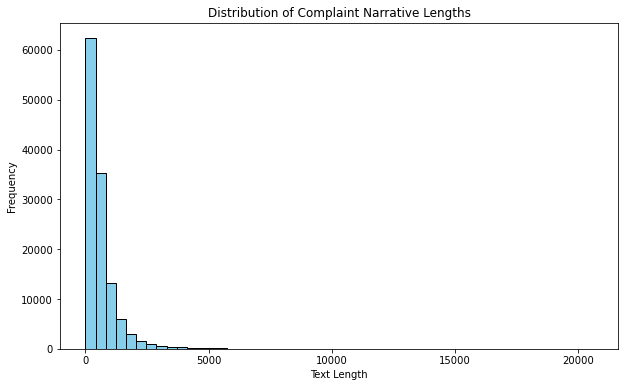

count    124676.000000
mean        633.359484
std         832.511639
min           3.000000
25%         219.000000
50%         414.000000
75%         752.000000
max       20596.000000
Name: text_length, dtype: float64

In [9]:
import matplotlib.pyplot as plt

# Calculating the length of each complaint narrative
complaints_data['text_length'] = complaints_data['narrative'].apply(len)

# Summary statistics for text length
text_length_summary = complaints_data['text_length'].describe()

# Plotting the distribution of text length
plt.figure(figsize=(10, 6))
plt.hist(complaints_data['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Complaint Narrative Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

text_length_summary

In [12]:

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# define the preprocessing function
def preprocess_text(text):
    # Check if text is a valid string
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'\W|\d', ' ', text)
        # Tokenize and remove stopwords
        words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
        # Join words back to string
        return ' '.join(words)
    else:
        # Return an empty string if the text is NaN
        return ''

# Apply preprocessing

complaints_data['processed_text'] = complaints_data['narrative'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# Displaying a sample of the cleaned narratives
complaints_data[['narrative', 'processed_text']].head()

,narrative,processed_text
0,purchase order day shipping amount receive product week sent followup email exact verbiage paid two day shipping received order company responded im sorry inform due unusually high order volume order shipped several week stock since early due high demand although continuing take order guaranteeing receive order place due time mask order exact shipping date right however guarantee ship soon soon delivers product u getting small shipment shipping first come first served basis appreciate patience fulfill order quickly recommend keeping order lose place line cancel distributor stock moment prefer cancel please note ask via email cancel accordance cancellation policy agreed checkout electronic inventory online requested order canceled refund issued canceled order sent verification order canceled refunded item particulate respirator refunded subtotal shipping tax total usd visa ending refund called disputed amount stated nothing needed submitted address issue recharged item removing called back dispute amount transaction rebillmerchandiserobert ca purchased thu posted wed purchased appears statement transaction rebill ca u followed see status case submitted documentation showing canceled order supposed submit refund called back speak manager case stated dispute ruled favor charge removed card capital one removed purchase bill purchase adjustmentmerchandiserobert j posted fri purchased appears statement purchase adjustment capital one recharges amount transaction rebillmerchandiserobert j purchased thu posted mon purchased appears statement transaction rebill called capital one requested recharge stated visa ruled case pretended remove purchase knew anything case manager ruling favor,purchase order day shipping amount receive product week sent followup email exact verbiage paid two day shipping received order company responded im sorry inform due unusually high order volume order shipped several week stock since early due high demand although continuing take order guaranteeing receive order place due time mask order exact shipping date right however guarantee ship soon soon delivers product u getting small shipment shipping first come first served basis appreciate patience fulfill order quickly recommend keeping order lose place line cancel distributor stock moment prefer cancel please note ask via email cancel accordance cancellation policy agreed checkout electronic inventory online requested order canceled refund issued canceled order sent verification order canceled refunded item particulate respirator refunded subtotal shipping tax total usd visa ending refund called disputed amount stated nothing needed submitted address issue recharged item removing called back dispute amount transaction rebillmerchandiserobert ca purchased thu posted wed purchased appears statement transaction rebill ca u followed see status case submitted documentation showing canceled order supposed submit refund called back speak manager case stated dispute ruled favor charge removed card capital one removed purchase bill purchase adjustmentmerchandiserobert j posted fri purchased appears statement purchase adjustment capital one recharges amount transaction rebillmerchandiserobert j purchased thu posted mon purchased appears statement transaction rebill called capital one requested recharge stated visa ruled case pretended remove purchase knew anything case manager ruling favor
1,forwarded message date tue subject please investigate comenity bank retailer card scam sent hello name scammed comenity bank credit card provider company childrens place new york forever victoria secret original credit comenity bank lower limit began charge overage fee along late fee began pay close attention card find limit also changed well incurring overage late fee reached company comenity bank stated would change credit limit original limit reached told summit payment account corrected comenity bank credit card impacted credit score plummeted nega

### EDA

In [14]:
# Word Frequency
word_freq = Counter(" ".join(complaints_data['processed_text']).split())
print(word_freq.most_common(10))

# Bigrams and Trigrams
bigrams = Counter(ngrams(" ".join(complaints_data['processed_text']).split(), 2))
trigrams = Counter(ngrams(" ".join(complaints_data['processed_text']).split(), 3))
print(bigrams.most_common(10))
print(trigrams.most_common(10))

[('account', 252929), ('credit', 239624), ('report', 124293), ('payment', 118364), ('information', 104300), ('time', 73355), ('would', 72341), ('loan', 70670), ('company', 67883), ('card', 66771)]
[(('credit', 'report'), 69666), (('credit', 'card'), 26508), (('credit', 'bureau'), 21540), (('credit', 'reporting'), 19092), (('identity', 'theft'), 16530), (('credit', 'score'), 13375), (('account', 'number'), 12264), (('late', 'payment'), 12030), (('customer', 'service'), 11633), (('reporting', 'agency'), 11517)]
[(('fair', 'credit', 'reporting'), 8697), (('credit', 'reporting', 'act'), 8650), (('credit', 'reporting', 'agency'), 6159), (('victim', 'identity', 'theft'), 4849), (('consumer', 'reporting', 'agency'), 4599), (('information', 'credit', 'report'), 4487), (('account', 'credit', 'report'), 3983), (('removed', 'credit', 'report'), 3673), (('social', 'security', 'number'), 3146), (('opened', 'balance', 'account'), 3135)]


In [15]:
# Checking the distribution of the 'product' categories
product_distribution = complaints_data['product'].value_counts()

product_distribution

credit_reporting       56303
debt_collection        21117
mortgages_and_loans    18759
credit_card            15024
retail_banking         13473
Name: product, dtype: int64

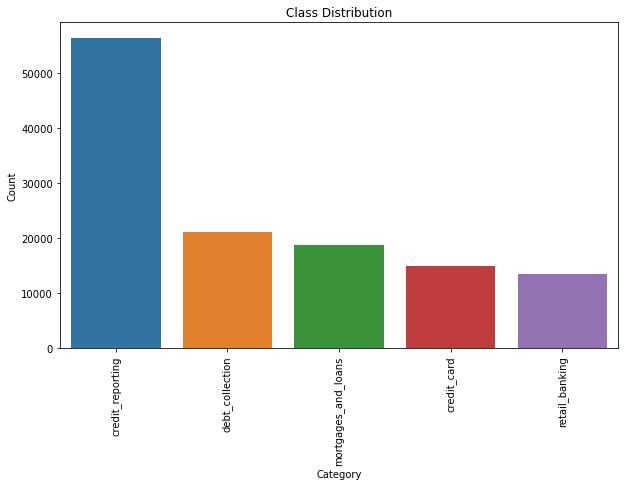

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def class_distribution_plot(title: str, x):
    # Calculate counts and sort by descending order
    value_counts = x.value_counts().sort_values(ascending=False)
    
    # Plot the sorted values
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=90)  # Rotate x labels if needed
    plt.show()


class_distribution_plot('Class Distribution', complaints_data['product'])


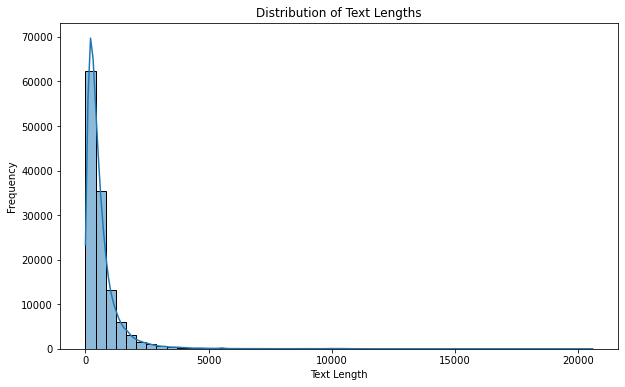

In [17]:
# Calculate the length of each complaint
complaints_data['text_length'] = complaints_data['narrative'].astype(str).apply(len)

# Plot the distribution of text length
plt.figure(figsize=(10, 6))
sns.histplot(complaints_data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


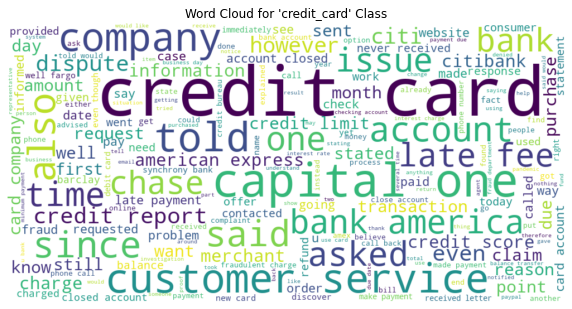

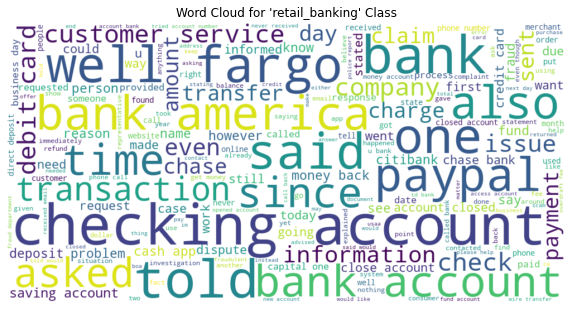

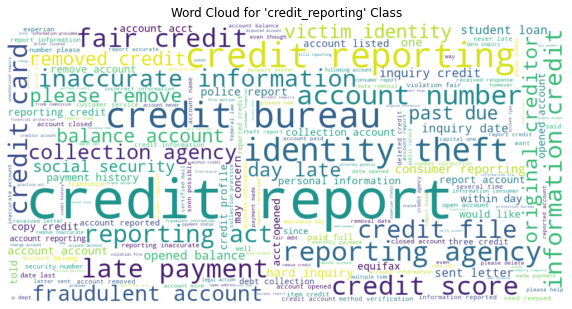

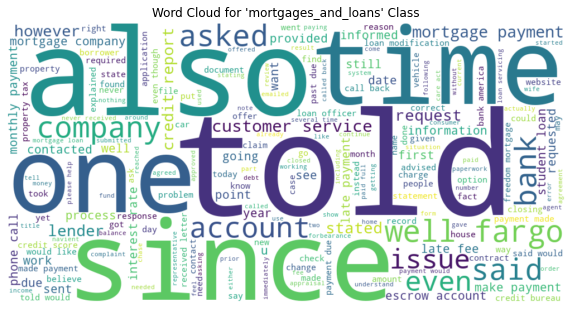

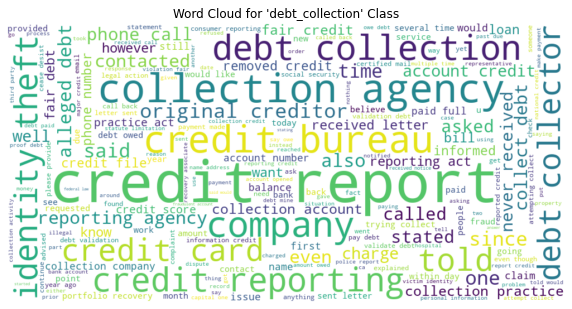

In [18]:
def wordcloud_for_class(title:str, text:str):
    wordcloud = WordCloud(width=1000, height=500, background_color='white', stopwords=set(stopwords.words('english'))).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show
    
for product_class in complaints_data["product"].unique():
    class_text = ' '.join(complaints_data[complaints_data['product'] == product_class]['processed_text'])
    wordcloud_for_class(f"Word Cloud for '{product_class}' Class", class_text)

In [19]:
# Calculate text length if not already present
if 'text_length' not in complaints_data.columns:
    complaints_data['text_length'] = complaints_data['processed_text'].apply(len)

# Calculate word count if not already present
if 'number_of_words' not in complaints_data.columns:
    complaints_data['number_of_words'] = complaints_data['processed_text'].apply(lambda x: len(x.split()))

# Adding text length column (character count for each narrative)
complaints_data['text_length'] = complaints_data['processed_text'].apply(len)

# Adding word count column (number of words in each narrative)
complaints_data['number_of_words'] = complaints_data['processed_text'].apply(lambda x: len(x.split()))

# Display the relevant columns in the DataFrame
cleaned_complaints_data = complaints_data[['product', 'processed_text', 'text_length', 'number_of_words']]

# View the first few rows
cleaned_complaints_data.head()

,product,processed_text,text_length,number_of_words
0,credit_card,purchase order day shipping amount receive product week sent followup email exact verbiage paid two day shipping received order company responded im sorry inform due unusually high order volume order shipped several week stock since early due high demand although continuing take order guaranteeing receive order place due time mask order exact shipping date right however guarantee ship soon soon delivers product u getting small shipment shipping first come first served basis appreciate patience fulfill order quickly recommend keeping order lose place line cancel distributor stock moment prefer cancel please note ask via email cancel accordance cancellation policy agreed checkout electronic inventory online requested order canceled refund issued canceled order sent verification order canceled refunded item particulate respirator refunded subtotal shipping tax total usd visa ending refund called disputed amount stated nothing needed submitted address issue recharged item removing called back dispute amount transaction rebillmerchandiserobert ca purchased thu posted wed purchased appears statement transaction rebill ca u followed see status case submitted documentation showing canceled order supposed submit refund called back speak manager case stated dispute ruled favor charge removed card capital one removed purchase bill purchase adjustmentmerchandiserobert j posted fri purchased appears statement purchase adjustment capital one recharges amount transaction rebillmerchandiserobert j purchased thu posted mon purchased appears statement transaction rebill called capital one requested recharge stated visa ruled case pretended remove purchase knew anything case manager ruling favor,1705,230
1,credit_card,forwarded message date tue subject please investigate comenity bank retailer card scam sent hello name scammed comenity bank credit card provider company childrens place new york forever victoria secret original credit comenity bank lower limit began charge overage fee along late fee began pay close attention card find limit also changed well incurring overage late fee reached company comenity bank stated would change credit limit original limit reached told summit payment account corrected comenity bank credit card impacted credit score plummeted negative status im currently paying price due corruption affected detrimental way debt due company charging overage fee well late fee even initial credit limit fluctuating tremendously company charge major fee account willing correct account nervous said attorney reason im reaching im employee company ruining credit plz help name contact info thank,904,132
2,retail_banking,forwarded message cc sent friday pdt subject final legal payment well fargo well fargo clearly wrong need look actually opened account see court hearing several different government agency reporting well including branch put open account numerous fraudulent charge debit card connected account clearly due fact well fargo maintain clearly required encryption card keep secure adding damage request small claim lawsuit time take away running business branch required come branch multiple time get fraudulent charge removed actually present strong case proper consumer protection agency well fargo immediately barred issuing account debit card insure agency card adequate prevent fraudulent use also requesting punitive treble damage sum hour take work handle lawsuit along legal cost filing lawsuit county small claim court today well fargo outrageous fraudulent conduct clearly warrant punitive damage also sharing every possible consumer protection agency find would think well fargo enough adverse publicity fraudulent conduct last year introduce small claim suit clearly establishing well fargo established business practice fraud customer ca judge really need reminded might want immediately run bonus payment legal department,1230,173
3,credit_reporting,payment history 

In [21]:
from sklearn.model_selection import train_test_split

# Separate the features (X) and target (y)
X = cleaned_complaints_data['processed_text']
y = cleaned_complaints_data['product']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting splits
print("Training set shapes (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shapes (X_test, y_test):", X_test.shape, y_test.shape)


Training set shapes (X_train, y_train): (99740,) (99740,)
Testing set shapes (X_test, y_test): (24936,) (24936,)


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)



In [23]:
from sklearn.preprocessing import MinMaxScaler
# Apply MinMax Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train_tfidf.toarray())
X_test_scaled = scaler.transform(X_test_tfidf.toarray())

# Print the shapes of the transformed features to verify
print("Scaled Training set shape:", X_train_scaled.shape)
print("Scaled Testing set shape:", X_test_scaled.shape)

Scaled Training set shape: (99740, 5000)
Scaled Testing set shape: (24936, 5000)


### Model Selection & Training

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Step 1: Initialize and train the Logistic Regression model
baseline_lr_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_lr_model.fit(X_train_scaled, y_train)

# Step 2: Make predictions on the test set
y_pred_base_lr = baseline_lr_model.predict(X_test_scaled)

# Step 3: Calculate accuracy and classification report
accuracy_base_lr = accuracy_score(y_test, y_pred_base_lr)
report_base_lr = classification_report(y_test, y_pred_base_lr)

# Step 4: Display the evaluation scores
print(f"Accuracy (Baseline Logistic Regression): {accuracy_base_lr}")
print("Classification Report (Baseline Logistic Regression):\n", report_base_lr)

Accuracy (Baseline Logistic Regression): 0.8441610522938723
Classification Report (Baseline Logistic Regression):
                      precision    recall  f1-score   support

        credit_card       0.79      0.77      0.78      3004
   credit_reporting       0.88      0.89      0.88     11338
    debt_collection       0.80      0.75      0.77      4157
mortgages_and_loans       0.84      0.84      0.84      3741
     retail_banking       0.85      0.87      0.86      2696

           accuracy                           0.84     24936
          macro avg       0.83      0.82      0.83     24936
       weighted avg       0.84      0.84      0.84     24936



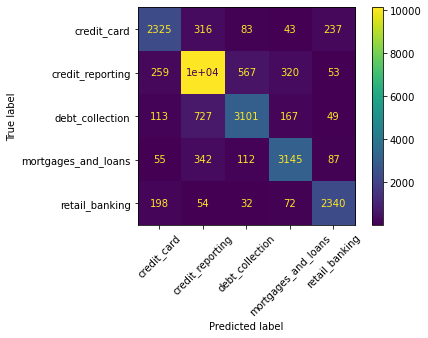

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(baseline_lr_model, X_test_scaled, y_test, xticks_rotation=45)
plt.show()


In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Initialize and train the Multinomial Naive Bayes model
baseline_nb_model = MultinomialNB()
baseline_nb_model.fit(X_train_scaled, y_train)

# Step 2: Make predictions on the test set
y_pred_base_nb = baseline_nb_model.predict(X_test_scaled)

# Step 3: Calculate accuracy and classification report
accuracy_base_nb = accuracy_score(y_test, y_pred_base_nb)
report_base_nb = classification_report(y_test, y_pred_base_nb)

# Step 4: Display the evaluation scores
print(f"Accuracy (Baseline MultinomialNB): {accuracy_base_nb}")
print("Classification Report (Baseline MultinomialNB):\n", report_base_nb)

Accuracy (Baseline MultinomialNB): 0.8046198267564967
Classification Report (Baseline MultinomialNB):
                      precision    recall  f1-score   support

        credit_card       0.70      0.75      0.73      3004
   credit_reporting       0.86      0.84      0.85     11338
    debt_collection       0.78      0.65      0.71      4157
mortgages_and_loans       0.76      0.87      0.81      3741
     retail_banking       0.81      0.86      0.83      2696

           accuracy                           0.80     24936
          macro avg       0.78      0.79      0.79     24936
       weighted avg       0.81      0.80      0.80     24936



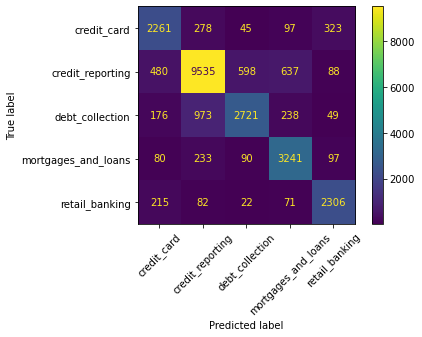

In [30]:
# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(baseline_nb_model, X_test_scaled, y_test, xticks_rotation=45)
plt.show()


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Initialize and train the Random Forest model
baseline_rf_model = RandomForestClassifier(random_state=42)
baseline_rf_model.fit(X_train_scaled, y_train)

# Step 2: Make predictions on the test set
y_pred_base_rf = baseline_rf_model.predict(X_test_scaled)

# Step 3: Calculate accuracy and classification report
accuracy_base_rf = accuracy_score(y_test, y_pred_base_rf)
report_base_rf = classification_report(y_test, y_pred_base_rf)

# Step 4: Display the evaluation scores
print(f"Accuracy (Baseline Random Forest): {accuracy_base_rf}")
print("Classification Report (Baseline Random Forest):\n", report_base_rf)

Accuracy (Baseline Random Forest): 0.8514998395893487
Classification Report (Baseline Random Forest):
                      precision    recall  f1-score   support

        credit_card       0.82      0.73      0.77      3004
   credit_reporting       0.85      0.95      0.90     11338
    debt_collection       0.85      0.72      0.78      4157
mortgages_and_loans       0.88      0.82      0.85      3741
     retail_banking       0.84      0.84      0.84      2696

           accuracy                           0.85     24936
          macro avg       0.85      0.81      0.83     24936
       weighted avg       0.85      0.85      0.85     24936



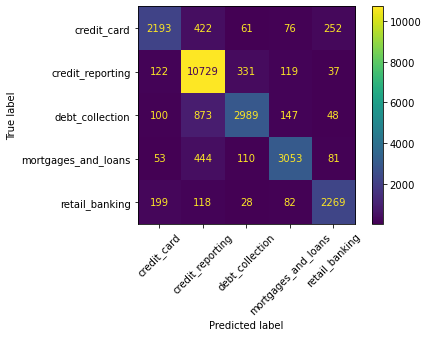

In [32]:
# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(baseline_rf_model, X_test_scaled, y_test, xticks_rotation=45)
plt.show()